In [85]:
from __future__ import annotations

from pathlib import Path
import re

import pandas as pd
import matplotlib.pyplot as plt

In [86]:
root = Path.cwd().resolve()

if root.name == "notebooks":
    root = root.parent

data_direct = root/ "data"
raw_direct = data_direct/ "raw"
interim_direct = data_direct/ "interim"
processed_direct = data_direct/ "processed"

reports_direct = root / "reports"
figures_direct = reports_direct / "figures"
tables_direct = reports_direct / "tables"

for p in [interim_direct, processed_direct, figures_direct, tables_direct]:
    p.mkdir(parents=True, exist_ok=True)

In [87]:
sep = r"\+\+\+\$\+\+\+"

conv_fp = raw_direct / "supreme.conversations.txt"
votes_fp = raw_direct / "supreme.votes.txt"
out_fp = raw_direct / "supreme.outcome.txt"
gender_fp = raw_direct / "supreme.gender.txt"

for fp in [conv_fp, votes_fp, out_fp, gender_fp]:
    if not fp.exists():
        raise FileNotFoundError(f"Missing File: {fp}")

print("All dataset files are present. Let's start.")

All dataset files are present. Let's start.


In [88]:
def read_conversations(fp: Path) -> pd.DataFrame:

    cols = [
        "case_id",
        "utt_id",
        "after_prev",
        "speaker",
        "is_justice",
        "justice_vote",
        "presentation_side",
        "utt",
    ]

    df = pd.read_csv(
        fp,
        sep=sep,
        header=None,
        names=cols,
        engine="python",
        dtype=str,
        on_bad_lines="skip",
    )

    df["utt_id"] = pd.to_numeric(df["utt_id"], errors="coerce")
    df["after_prev"] = df["after_prev"].map({"TRUE": True, "FALSE": False})

    return df


def read_outcome(fp: Path) -> pd.DataFrame:

    df = pd.read_csv(
        fp,
        sep=sep,
        header=None,
        names=["case_id", "winning_side"],
        engine="python",
        dtype=str,
        on_bad_lines="skip",
    )

    return df


def read_gender(fp: Path) -> pd.DataFrame:

    df = pd.read_csv(
        fp,
        sep=sep,
        header=None,
        names=["speaker", "gender"],
        engine="python",
        dtype=str,
        on_bad_lines="skip",
    )

    return df


def read_votes(fp: Path) -> pd.DataFrame:

    rows = []

    with fp.open("r", encoding="utf-8", errors="replace") as f:
        for line in f:
            parts = [p.strip() for p in line.rstrip("\n").split(sep)]
            if not parts or len(parts) < 2:
                continue
            case_id = parts[0]
            for item in parts[1:]:
                if "::" not in item:
                    continue
                j, v = item.split("::", 1)
                rows.append((case_id, j.strip(), v.strip()))

    return pd.DataFrame(rows, columns=["case_id", "justice_name", "vote"])


conv = read_conversations(conv_fp)
out = read_outcome(out_fp)
gen = read_gender(gender_fp)
votes = read_votes(votes_fp)

print("Conversations Shape:", conv.shape)
print("Outcome Shape:", out.shape)
print("Gender Shape:", gen.shape)
print("Votes Shape:", votes.shape)

Conversations Shape: (51498, 8)
Outcome Shape: (196, 2)
Gender Shape: (326, 2)
Votes Shape: (0, 3)


In [89]:
conv.head(3)
out.head(3)
votes.head(5)
gen.head(5)

print("Unique Cases in Conversations:", conv["case_id"].nunique())
print("Unique Speakers:", conv["speaker"].nunique())

print("Utterances:", len(conv))
print("Justice Utterances:", int((conv["is_justice"] == "JUSTICE").sum()))
print("Non-Justice Utterances:", int((conv["is_justice"] != "JUSTICE").sum()))

print("Winning Counts:")
print(out["winning_side"].value_counts(dropna=False))

print("Missing Values in Conversations:")
print(conv.isna().sum().sort_values(ascending=False).head(12))

Unique Cases in Conversations: 204
Unique Speakers: 326
Utterances: 51498
Justice Utterances: 0
Non-Justice Utterances: 51498
Winning Counts:
winning_side
PETITIONER    134
RESPONDENT     62
Name: count, dtype: int64
Missing Values in Conversations:
after_prev           51498
case_id                  0
utt_id                   0
speaker                  0
is_justice               0
justice_vote             0
presentation_side        0
utt                      0
dtype: int64


In [90]:
is_j = conv["is_justice"].eq("JUSTICE")
print("Justice Utterances:", int(is_j.sum()))
print("Non-Justice Utterances:", int((~is_j).sum()))

conv = conv.merge(gen, on="speaker", how="left")
conv["gender"] = conv["gender"].fillna("na")

conv2 = conv.merge(out, on="case_id", how="left")

print("Cases in Conversations:", conv2["case_id"].nunique())
print("Cases with Missing Outcome:", int(conv2.drop_duplicates("case_id")["winning_side"].isna().sum()))

def tok_simple(s: str) -> list[str]:
    return re.findall(r"[A-Za-z0-9']+", s.lower())


utt_s = conv2["utt"].fillna("").astype(str)

conv2["utt_chars"] = utt_s.str.len()
conv2["utt_toks"] = utt_s.map(lambda x: len(tok_simple(x)))
conv2["is_q"] = utt_s.str.contains(r"\?", regex=True)
conv2["is_empty"] = utt_s.str.strip().eq("")

Justice Utterances: 0
Non-Justice Utterances: 51498
Cases in Conversations: 204
Cases with Missing Outcome: 8


In [91]:
print("Empty Utterances:", int(conv2["is_empty"].sum()))
print("Question Utterances:",int(conv2["is_q"].sum()))
print("Question Rate:", float(conv2["is_q"].mean()))
print("Median Tokens per Utterance:", float(conv2["utt_toks"].median()))
print("95th Percentile Tokens per Utterance:", float(conv2["utt_toks"].quantile(0.95)))

Empty Utterances: 0
Question Utterances: 11869
Question Rate: 0.23047496990174376
Median Tokens per Utterance: 20.0
95th Percentile Tokens per Utterance: 140.0


In [92]:
case_stats = (
    conv2.groupby("case_id", as_index=False)
    .agg(
        utt_n=("utt_id", "count"),
        speaker_n=("speaker", "nunique"),
        justice_utt_n=("is_justice", lambda x: (x == "JUSTICE").sum()),
        nonjustice_utt_n=("is_justice", lambda x: (x != "JUSTICE").sum()),
        tok_n=("utt_toks", "sum"),
        tok_med=("utt_toks", "median"),
        q_rate=("is_q", "mean"),
        empty_n=("is_empty", "sum"),
        pet_utt_n=("presentation_side", lambda x: (x == "PETITIONER").sum()),
        resp_utt_n=("presentation_side", lambda x: (x == "RESPONDENT").sum()),
    )
)

case_out = out.drop_duplicates("case_id")
case_stats = case_stats.merge(case_out, on="case_id", how="left")

case_stats["side_total"] = case_stats["pet_utt_n"] + case_stats["resp_utt_n"]
case_stats["pet_share"] = case_stats["pet_utt_n"] / case_stats["side_total"].replace(0, pd.NA)
case_stats["resp_share"] = case_stats["resp_utt_n"] / case_stats["side_total"].replace(0, pd.NA)

print("Case Stats Rows:", len(case_stats))

Case Stats Rows: 204


In [93]:
print("Top Cases by Utterances:")
display(case_stats.sort_values("utt_n", ascending=False).head(10))

print("Top Cases by Tokens:")
display(case_stats.sort_values("tok_n", ascending=False).head(10))

Top Cases by Utterances:


,case_id,utt_n,speaker_n,justice_utt_n,nonjustice_utt_n,tok_n,tok_med,q_rate,empty_n,pet_utt_n,resp_utt_n,winning_side,side_total,pet_share,resp_share
88,04-373,585,11,0,585,10887,5.0,0.136752,0,0,0,RESPONDENT,0,<NA>,<NA>
123,04-9728,502,11,0,502,10545,6.0,0.159363,0,0,0,RESPONDENT,0,<NA>,<NA>
6,03-1164,463,10,0,463,10622,7.0,0.118790,0,0,0,PETITIONER,0,<NA>,<NA>
113,04-721,440,10,0,440,10629,7.0,0.190909,0,0,0,PETITIONER,0,<NA>,<NA>
150,05-204,421,12,0,421,21246,29.0,0.235154,0,0,0,PETITIONER,0,<NA>,<NA>
116,04-848,408,10,0,408,9781,6.5,0.142157,0,0,0,PETITIONER,0,<NA>,<NA>
120,04-905,399,10,0,399,10288,8.0,0.157895,0,0,0,PETITIONER,0,<NA>,<NA>
54,04-1152,397,10,0,397,10537,8.0,0.136020,0,0,0,PETITIONER,0,<NA>,<NA>
106,04-631,393,11,0,393,10784,9.0,0.195929,0,0,0,PETITIONER,0,<NA>,<NA>
162,05-547,393,11,0,393,9981,6.0,0.157761,0,0,0,PETITIONER,0,<NA>,<NA>


Top Cases by Tokens:


,case_id,utt_n,speaker_n,justice_utt_n,nonjustice_utt_n,tok_n,tok_med,q_rate,empty_n,pet_utt_n,resp_utt_n,winning_side,side_total,pet_share,resp_share
150,05-204,421,12,0,421,21246,29.0,0.235154,0,0,0,PETITIONER,0,<NA>,<NA>
148,05-184,374,9,0,374,15613,14.0,0.195187,0,0,0,PETITIONER,0,<NA>,<NA>
111,04-70,323,11,0,323,15560,16.0,0.157895,0,0,0,RESPONDENT,0,<NA>,<NA>
48,04-10566,375,13,0,375,14888,22.0,0.285333,0,0,0,RESPONDENT,0,<NA>,<NA>
47,04-1034,339,11,0,339,14122,23.0,0.227139,0,0,0,PETITIONER,0,<NA>,<NA>
67,04-1360b,355,11,0,355,11670,19.0,0.245070,0,0,0,NaN,0,<NA>,<NA>
65,04-1350,203,11,0,203,11555,24.0,0.290640,0,0,0,PETITIONER,0,<NA>,<NA>
98,04-5462,254,10,0,254,11504,21.0,0.244094,0,0,0,PETITIONER,0,<NA>,<NA>
22,03-184,323,9,0,323,11384,22.0,0.229102,0,0,0,PETITIONER,0,<NA>,<NA>
167,05-5992,218,9,0,218,11345,32.5,0.243119,0,0,0,PETITIONER,0,<NA>,<NA>


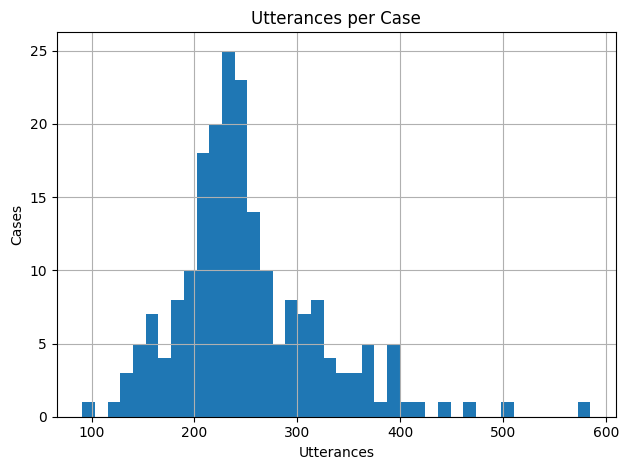

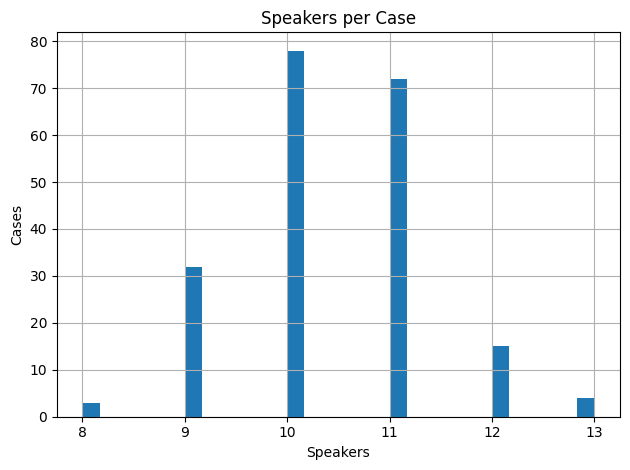

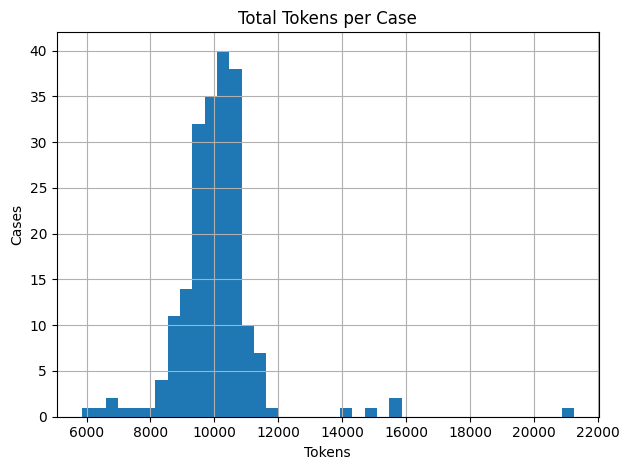

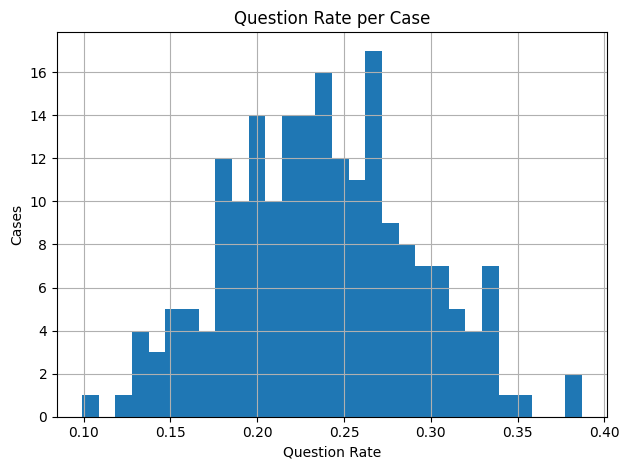

In [94]:
plt.figure()
case_stats["utt_n"].hist(bins=40)
plt.title("Utterances per Case")
plt.xlabel("Utterances")
plt.ylabel("Cases")
plt.tight_layout()
plt.show()

plt.figure()
case_stats["speaker_n"].hist(bins=30)
plt.title("Speakers per Case")
plt.xlabel("Speakers")
plt.ylabel("Cases")
plt.tight_layout()
plt.show()

plt.figure()
case_stats["tok_n"].hist(bins=40)
plt.title("Total Tokens per Case")
plt.xlabel("Tokens")
plt.ylabel("Cases")
plt.tight_layout()
plt.show()

plt.figure()
case_stats["q_rate"].hist(bins=30)
plt.title("Question Rate per Case")
plt.xlabel("Question Rate")
plt.ylabel("Cases")
plt.tight_layout()
plt.show()


Utterances by presentation side:
presentation_side
PETITIONER     25697
RESPONDENT     25147
None             446
                 208
Name: count, dtype: int64


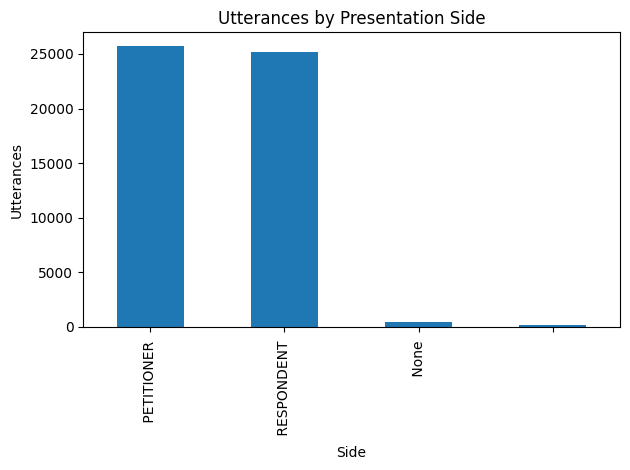

In [95]:
side_global = conv2["presentation_side"].fillna("EMPTY").value_counts()
print("Utterances by presentation side:")
print(side_global)

plt.figure()
side_global.plot(kind="bar")
plt.title("Utterances by Presentation Side")
plt.xlabel("Side")
plt.ylabel("Utterances")
plt.tight_layout()
plt.show()

Speakers by gender:
gender
male      266
female     57
NA          3
Name: count, dtype: int64
Utterances by gender:
gender
na    51498
Name: count, dtype: int64


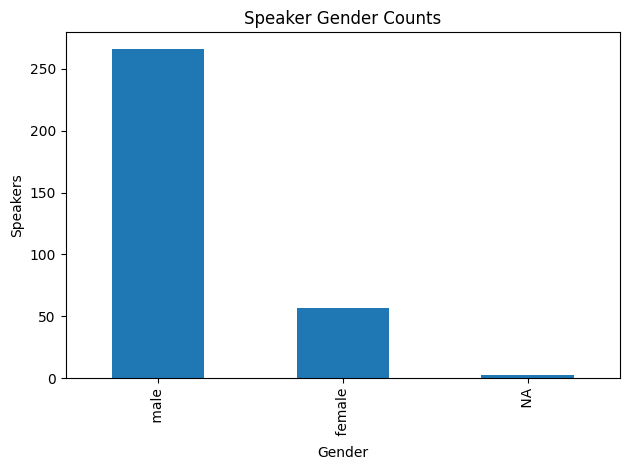

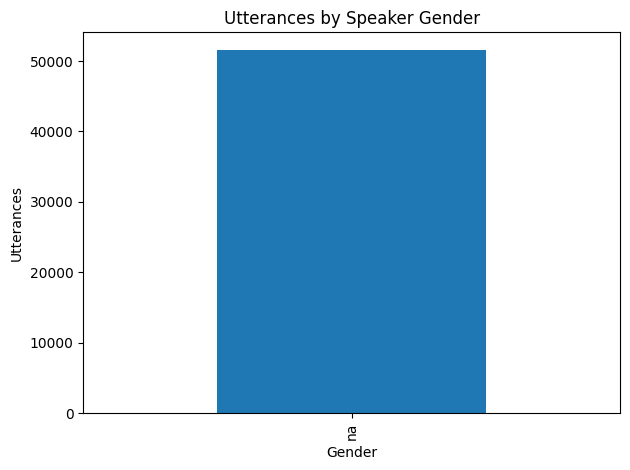

In [96]:
gender_speaker = gen["gender"].value_counts(dropna=False)
print("Speakers by gender:")
print(gender_speaker)

gender_utt = conv2["gender"].value_counts(dropna=False)
print("Utterances by gender:")
print(gender_utt)

plt.figure()
gender_speaker.plot(kind="bar")
plt.title("Speaker Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Speakers")
plt.tight_layout()
plt.show()

plt.figure()
gender_utt.plot(kind="bar")
plt.title("Utterances by Speaker Gender")
plt.xlabel("Gender")
plt.ylabel("Utterances")
plt.tight_layout()
plt.show()

Case-level summary by outcome:


,winning_side,cases,utt_med,utt_mean,tok_med,tok_mean,q_med
0,PETITIONER,134,241.0,250.604478,10086.0,10094.328358,0.235416
1,RESPONDENT,62,238.0,254.967742,10028.5,9976.435484,0.234852


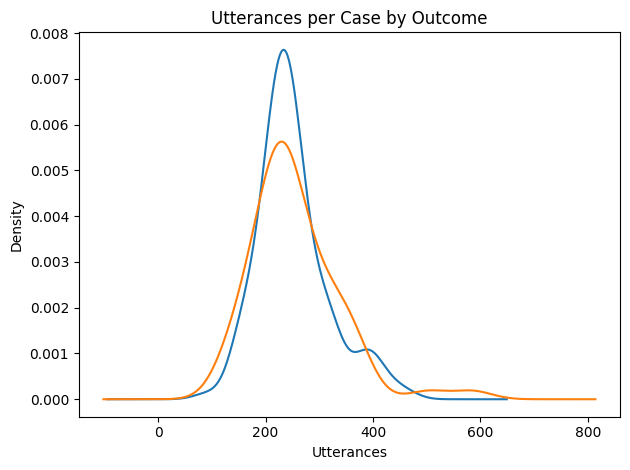

In [97]:
labelled = case_stats.dropna(subset=["winning_side"]).copy()

by_out = labelled.groupby("winning_side", as_index=False).agg(
    cases=("case_id", "count"),
    utt_med=("utt_n", "median"),
    utt_mean=("utt_n", "mean"),
    tok_med=("tok_n", "median"),
    tok_mean=("tok_n", "mean"),
    q_med=("q_rate", "median"),
)

print("Case-level summary by outcome:")
display(by_out)

plt.figure()
for side in labelled["winning_side"].dropna().unique():
    labelled.loc[labelled["winning_side"] == side, "utt_n"].plot(kind="kde", label=side)
plt.title("Utterances per Case by Outcome")
plt.xlabel("Utterances")
plt.tight_layout()
plt.show()

In [98]:
leak_terms = [
    "we hold",
    "the judgment is",
    "it is so ordered",
    "reversed",
    "affirmed",
    "vacated",
    "remanded",
]

pat = re.compile("|".join(re.escape(t) for t in leak_terms), flags=re.IGNORECASE)

conv2["leak_hit"] = conv2["utt"].astype(str).map(lambda x: bool(pat.search(x)))
hit_n = int(conv2["leak_hit"].sum())
print("Potential leakage term hits:", hit_n)

if hit_n > 0:
    leak_ex = conv2.loc[conv2["leak_hit"], ["case_id", "speaker", "presentation_side", "utt"]].head(20)
    display(leak_ex)

Potential leakage term hits: 282


,case_id,speaker,presentation_side,utt
288,02-1472,MR. MILLER,PETITIONER,"Secondly, with regard to the core governmenta..."
461,02-1672,MR. THOMAS,RESPONDENT,"Well, Justice Breyer, on the face of the stat..."
541,02-1672,MR. DELLINGER,PETITIONER,I should make it clear that we're not asking ...
545,02-1672,MR. DELLINGER,PETITIONER,The practice of Congress has not been consist...
959,03-1039,MS. CORTINA,PETITIONER,"It's one reasonable inference, and that's wha..."
997,03-1039,MR. GITS,RESPONDENT,"Well, as we pointed out in our brief, this Co..."
1242,03-1116,MR. CASEY,PETITIONER,Despite the lack of evidence in the record an...
2320,03-1230,MR. BOYNTON,RESPONDENT,You could -- you can choose where to plate yo...
2990,03-1293,MS. SAMEK,PETITIONER,"In the district court, there were issues rais..."
3473,03-1395,MR. CLEMENT,PETITIONER,I would also say that the difference between ...


In [99]:
eda_fp = tables_direct / "eda_case_stats.csv"
case_stats.sort_values("utt_n", ascending=False).to_csv(eda_fp, index=False)
print("Saved case-level EDA table:", eda_fp)

fig1 = figures_direct / "eda_utterances_per_case.png"
fig2 = figures_direct / "eda_speakers_per_case.png"
fig3 = figures_direct / "eda_tokens_per_case.png"
fig4 = figures_direct / "eda_question_rate_per_case.png"

plt.figure()
case_stats["utt_n"].hist(bins=40)
plt.title("Utterances per Case")
plt.xlabel("Utterances")
plt.ylabel("Cases")
plt.tight_layout()
plt.savefig(fig1)
plt.close()

plt.figure()
case_stats["speaker_n"].hist(bins=30)
plt.title("Speakers per Case")
plt.xlabel("Speakers")
plt.ylabel("Cases")
plt.tight_layout()
plt.savefig(fig2)
plt.close()

plt.figure()
case_stats["tok_n"].hist(bins=40)
plt.title("Total Tokens per Case")
plt.xlabel("Tokens")
plt.ylabel("Cases")
plt.tight_layout()
plt.savefig(fig3)
plt.close()

plt.figure()
case_stats["q_rate"].hist(bins=30)
plt.title("Question Rate per Case")
plt.xlabel("Question Rate")
plt.ylabel("Cases")
plt.tight_layout()
plt.savefig(fig4)
plt.close()

print("Saved Figures:", fig1.name, fig2.name, fig3.name, fig4.name)

Saved case-level EDA table: /Users/Sumaitat/Coding Projects/ML_SupremeCourtOutcomePrediction/reports/tables/eda_case_stats.csv
Saved Figures: eda_utterances_per_case.png eda_speakers_per_case.png eda_tokens_per_case.png eda_question_rate_per_case.png
